In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Dataset
df_train_DT = pd.read_csv("data\TRAIN_PREPROCESED_DT.csv")
df_test_DT = pd.read_csv("data\TEST_PREPROCESED_DT.csv")

df_train_KNN = pd.read_csv("data\TRAIN_PREPROCESED_KNN.csv")
df_test_KNN = pd.read_csv("data\TEST_PREPROCESED_KNN.csv")

# Outlier Detection

In [16]:
target_name = 'emotional_intensity'

attributes = [col for col in df_train_DT.columns if col != target_name]

In [17]:
X_train = df_train_DT[attributes]
y_train = df_train_DT[target_name]
X_test = df_test_DT[attributes]
y_test = df_test_DT[target_name]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Checking performance of classification BEFORE outlier removal

In [19]:
# Checking performance of classification Before outlier removal
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define the hyperparameters to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Create a grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Use the best estimator to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_val)

# Print the evaluation metrics
print('Decision Tree Classifier Performance BEFORE removing outliers:')
print('Accuracy %s' % accuracy_score(y_val, y_pred))
print('F1-score %s' % f1_score(y_val, y_pred, average=None))
print(classification_report(y_val, y_pred))

Decision Tree Classifier Performance BEFORE removing outliers:
Accuracy 0.7264770240700219
F1-score [0.72885033 0.72406181]
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       245
           1       0.68      0.77      0.72       212

    accuracy                           0.73       457
   macro avg       0.73      0.73      0.73       457
weighted avg       0.73      0.73      0.73       457



### # Finding the best K and T

In [20]:
# Finding the best K and T
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# define a range of values for k and T
k_values = [5, 10, 15, 20]
T_values = [2, 5, 8, 10]

# initialize variables to store the best hyperparameters and performance
max_f1_score = 0
max_accuracy = 0
best_k = None
best_T = None

# iterate over all possible combinations of k and T
for k in k_values:
    for T in T_values:
        
        # calculate the in-degree of each vertex in the kNN graph
        n = X_train.shape[0] # number of vertices in graph
        graph = np.zeros((n, n))
        for i in range(n):
            distances = np.linalg.norm(X_train - X_train.iloc[i], axis=1)
            neighbors = np.argsort(distances)[1:k+1] # exclude self as nearest neighbor
            for j in neighbors:
                graph[i][j] = 1 # add directed edge from i to j
        in_degree = np.sum(graph, axis=0)

        # detect outliers based on in-degree threshold
        outliers = np.where(in_degree <= T)[0]
        inliers = np.where(in_degree > T)[0]

        # remove the outliers from the training set
        X_train_filtered = X_train.iloc[inliers]
        y_train_filtered = y_train.iloc[inliers]

        # train a decision tree classifier
        dtc = DecisionTreeClassifier(random_state=42)
        dtc.fit(X_train_filtered, y_train_filtered)

        # make predictions on the test set
        y_pred = dtc.predict(X_val)

        # evaluate the performance of the decision tree classifier
        f1 = f1_score(y_val, y_pred, average='weighted')
        acc = accuracy_score(y_val, y_pred)
        # print('k =', k, ', T =', T)
        # print('Accuracy:', acc)
        # print('F1 Score:', f1)
        # print(classification_report(y_test, y_pred)) 
        
        # update max_f1_score and max_accuracy if current values are higher
        if f1 > max_f1_score and acc > max_accuracy:
            max_f1_score = f1
            max_accuracy = acc
            best_k = k
            best_T = T
            
print('Best k =', best_k, ', Best T =', best_T)
print('Accuracy:', max_accuracy)
print('F1 Score:', max_f1_score)

Best k = 20 , Best T = 2
Accuracy: 0.700218818380744
F1 Score: 0.6993516653543365


In [29]:
from pyod.models.abod import ABOD
from pyod.utils import evaluate_print

clf_name = 'ABOD'
clf = ABOD(method = "fast")
clf.fit(X_train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [30]:
outliers = clf.predict(X_train)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1192,  179], dtype=int64))

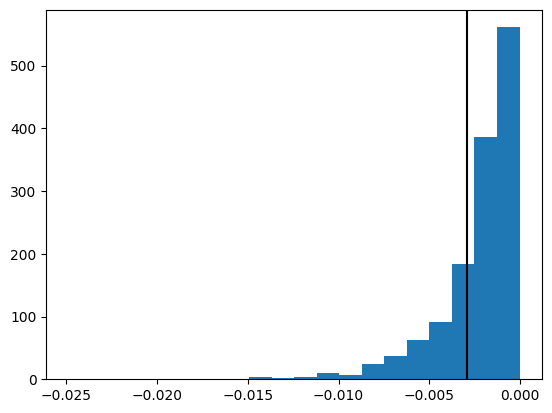

In [31]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

In [47]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_val_pred = clf.predict(X_val)  # outlier labels (0 or 1)
y_val_scores = clf.decision_function(X_val)  # outlier s`cores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_val, y_val_scores)

y_train_pred


On Training Data:
ABOD ROC:0.6184, precision @ rank n:0.5475

On Test Data:
ABOD ROC:0.6255, precision @ rank n:0.5755


array([0, 0, 0, ..., 0, 0, 0])

In [34]:
abod_model = ABOD(contamination=0.1, method= "fast", n_neighbors=10)
abod_model.fit(X_train)

pred = abod_model.predict(X_train)

error = (pred != y_train).sum()
print (f'Error % = {(error/len(pred))*100}')

Error % = 42.08606856309263
